# Notebook 3 - Handling continuous treatments by estimating causal curves (teacher notebook)

### For this analysis we'll be using the National Health and Nutrition Examination Survey III (NHANES III) dataset. NHANES III was conducted by the CDC and is a publicly available and PII- and PHI-free dataset. As part of NHANES III, the government interviewed and conducted laboratory tests on 1000s of U.S. residents. 

### We'll be focusing on the smaller, lead study within the larger NHANES study. It's well-known that both neonatal and childhood lead exposure leads to cognitive deficits in children. We're going to perform causal inference to see what would happen to cognitive test scores if we could reduce lead exposure at the population level. 

In [1]:
from os.path import expanduser
import warnings; warnings.filterwarnings("ignore")

from causal_curve import GPS_Regressor
from causal_curve import Mediation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

%matplotlib inline
pd.options.mode.chained_assignment = None
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [5, 4]

### Read in NHANES III data

In [2]:
# Windows users: replace the following line with `df = pd.read_csv(r"..\..\data\NHANES_III.csv")`
df = pd.read_csv("../../data/NHANES_III.csv")

The NHANES III dataset should contain the following columns:

__Race_NH_Black__<br>
   $\;\;\;\;\;\;$Is the race/ethnicity child Non-Hispanic Black?<br>
__Race_NH_White__<br>
    $\;\;\;\;\;\;$Is the race/ethnicity child Non-Hispanic White?<br>
__Race_Other__<br>
    $\;\;\;\;\;\;$Is the race/ethnicity child Other?<br>
__Edu_HS__<br>
    $\;\;\;\;\;\;$Did the primary parent obtain at least a high school degree as their highest degree?<br>
__Edu_LT_HS__<br>
    $\;\;\;\;\;\;$Did the primary parent not obtain a high school degree?<br>
__Sex_Male__<br>
    $\;\;\;\;\;\;$Was the child male? (This old government data assumes binary sex)<br>
__Age__<br>
    $\;\;\;\;\;\;$What was the age of the child (in years) when tested?<br>
__PIR__<br>
    $\;\;\;\;\;\;$NHANES describes this as the "Poverty-income ratio", but this is actually a misnomer. Really, this is the income-to-poverty ratio (family income in numerator, local poverty-line in denominator). < 1 indicates a family income below the poverty line, 1 indicates family income is at the poverty line, > 1 means income is greater than the poverty line. <br>
__Smoke_Home_Yes__<br>
    $\;\;\;\;\;\;$Is there smoking going on in the home?<br>
__Food_Often_bad__<br>
    $\;\;\;\;\;\;$Does the child experience food insecurity often?<br>
__Food_Sometimes_bad__<br>
    $\;\;\;\;\;\;$Does the child experience food insecurity sometimes?<br>
__Smoke_Preg_No__<br>
    $\;\;\;\;\;\;$Was someone in the family smoking when the mother was pregnant with this child?<br>
__Baby_NICU_Yes__<br>
    $\;\;\;\;\;\;$Did the child spend any time in a Neonatal intensive care unit (NICU) after being born?<br>
__Math__<br>
    $\;\;\;\;\;\;$Math test score (already standardized)<br>
__Reading__<br>
    $\;\;\;\;\;\;$Reading test score (already standardized)<br>
__Block__<br>
    $\;\;\;\;\;\;$Block design test score (already standardized)<br>
__Digit__<br>
    $\;\;\;\;\;\;$Digit spanning test score (already standardized)<br>
__BLL__<br>
    $\;\;\;\;\;\;$Blood lead level (mcg/dL)<br>

In [3]:
df.head()

,Race_NH_Black,Race_NH_White,Race_Other,Edu_HS,Edu_LT_HS,Sex_Male,Age,PIR,Smoke_Home_Yes,Food_Often_bad,Food_Sometimes_bad,Smoke_Preg_No,Smoke_Preg_Yes,Baby_NICU_Yes,Math,Reading,Block,Digit,BLL
0,0,0,0,0,0,0,11.916667,3.173,0,0,0,1,0,0,6.0,10.0,11.0,7.0,3.9
1,0,1,0,0,0,1,6.583333,1.543,1,0,0,1,0,0,6.0,5.0,8.0,5.0,3.2
2,0,0,0,1,0,1,7.416667,0.156,1,0,1,1,0,0,9.0,1.0,9.0,7.0,2.5
3,0,0,0,0,1,1,8.916667,0.278,0,0,1,1,0,0,0.0,0.0,6.0,4.0,12.5
4,0,0,0,1,0,1,10.833333,0.892,0,0,0,1,0,0,8.0,9.0,11.0,5.0,5.9


### First, let's do a bit of exploratory analysis of our key variables

<div class="alert alert-success">
    <h3>EXERCISE: What does the distribution of blood lead values look like?</h3>
    <h3>Note: There is no minimal, safe level of lead exposure. However, a level of 5 mcg/dL or higher is generally regarded a point of alarm for children.</h3>
</div>

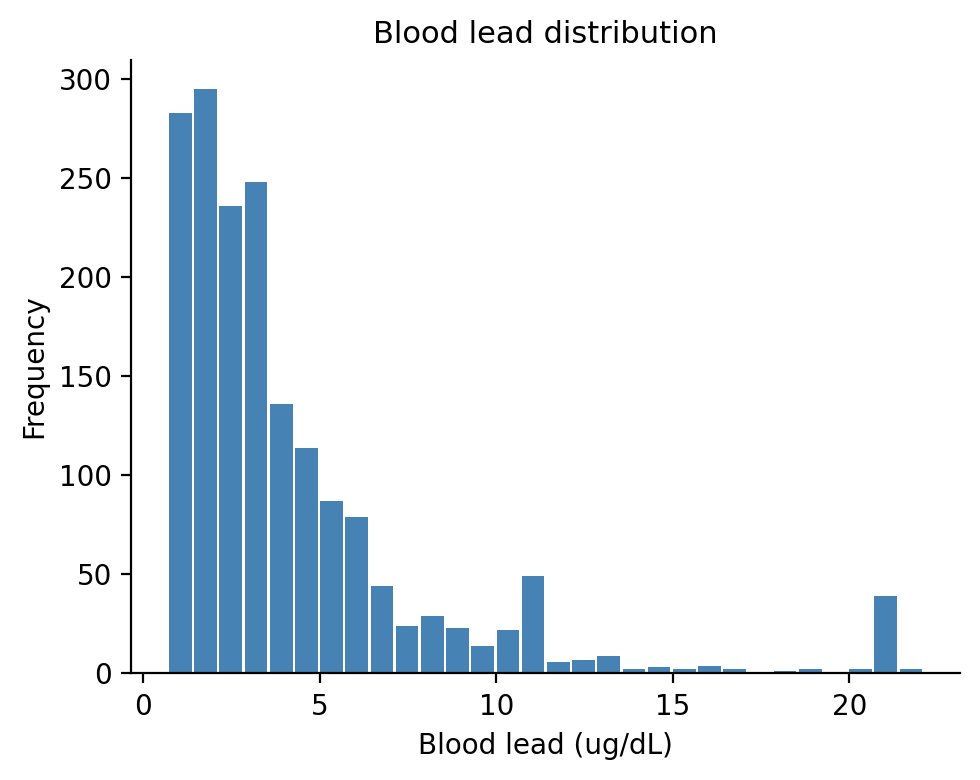

In [4]:
# Blood lead levels are log-normally distributed (an expected result...)

ax = plt.subplot(111)  
df['BLL'].plot.hist(bins = 30, rwidth=0.9, color = 'steelblue')
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
ax.set_ylabel('Frequency')
ax.set_xlabel('Blood lead (ug/dL)')
ax.set_title("Blood lead distribution", fontsize = 11)
plt.tight_layout()

<div class="alert alert-success">
    <h3>EXERCISE: What do the four cognitive test values look like? Do they appear to be normally-distributed?</h3>
</div>

Text(0.5, 0.98, 'Distributions of scaled test scores')

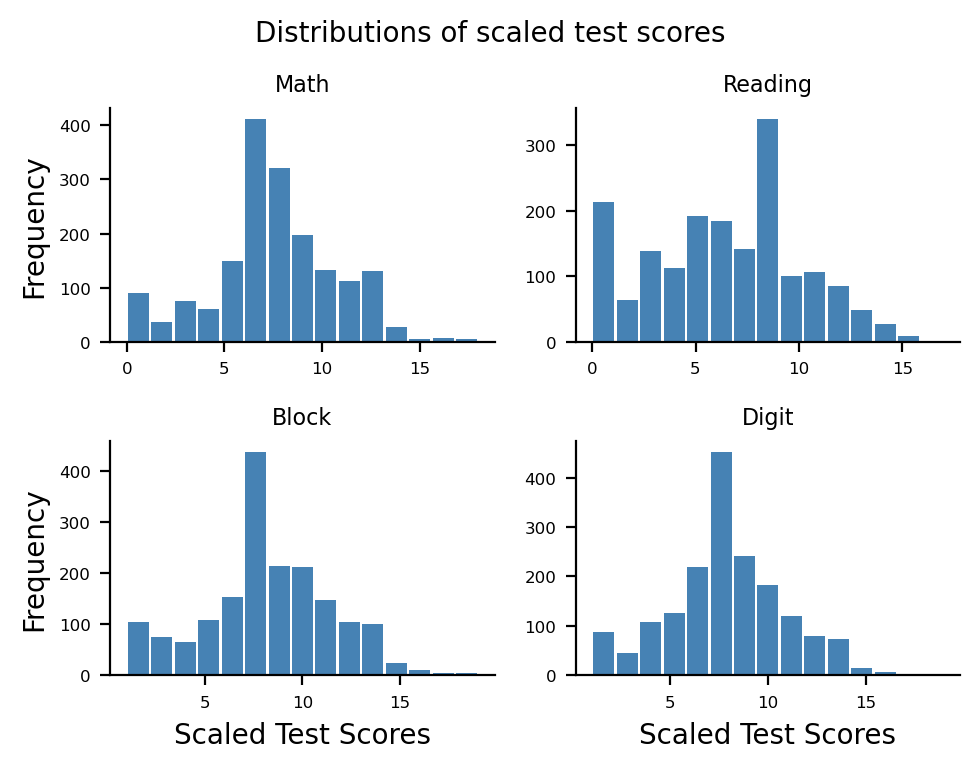

In [5]:
# See distribution of the scaled test scores

fig, axs = plt.subplots(2, 2)
df['Math'].plot.hist(ax=axs[0,0], bins = 15, rwidth=0.9, color = 'steelblue')
df['Reading'].plot.hist(ax=axs[0,1], bins = 15, rwidth=0.9, color = 'steelblue')
df['Block'].plot.hist(ax=axs[1,0], bins = 15, rwidth=0.9, color = 'steelblue')
df['Digit'].plot.hist(ax=axs[1,1], bins = 15, rwidth=0.9, color = 'steelblue')
axs[0,0].set_ylabel('Frequency')
axs[0,1].set_ylabel('')
axs[1,0].set_ylabel('Frequency')
axs[1,1].set_ylabel('')
axs[1,0].set_xlabel('Scaled Test Scores')
axs[1,1].set_xlabel('Scaled Test Scores')
axs[0,0].set_title("Math", fontsize = 8)
axs[0,1].set_title("Reading", fontsize = 8)
axs[1,0].set_title("Block", fontsize = 8)
axs[1,1].set_title("Digit", fontsize = 8)

for i in [0,1]:
    for j in [0,1]:
        axs[i,j].spines["top"].set_visible(False)
        axs[i,j].spines["right"].set_visible(False)
        axs[i,j].tick_params(axis='both', which='major', labelsize=6)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Distributions of scaled test scores", fontsize = 10)

### Now let's perform causal inference using the `causal-curve` package. Below is this code to conduct the analysis over each of the 4 test types. We store the results in the `results_dict` for safekeeping.

In [6]:
# Dictionary to store model results
results_dict = {}

# Potential confounders
potential_confounders = [
    'Age', 'Sex_Male', 'Race_NH_Black', 'Race_NH_White', 'Race_Other', 
    'Edu_HS', 'Edu_LT_HS', 'Smoke_Home_Yes', 'Baby_NICU_Yes', 'Food_Often_bad', 'Food_Sometimes_bad'
]


# Try the MATH model
math_gps = GPS_Regressor(gps_family='normal', lower_grid_constraint = 0.0, upper_grid_constraint = 0.99, n_splines = 5, verbose=False)
math_gps.fit(
    T=df['BLL'], 
    X=df[potential_confounders], 
    y=df['Math']
)

results_dict['math_CDRC'] = math_gps.calculate_CDRC()


# Try the READING model
reading_gps = GPS_Regressor(gps_family='normal', lower_grid_constraint = 0.0, upper_grid_constraint = 0.99, n_splines = 5, verbose=False)

reading_gps.fit(
    T=df['BLL'], 
    X=df[potential_confounders],  
    y=df['Reading']
)

results_dict['reading_CDRC'] = reading_gps.calculate_CDRC()



# Try the Block model
block_gps = GPS_Regressor(gps_family='normal', lower_grid_constraint = 0.0, upper_grid_constraint = 0.99, n_splines = 5, verbose=False)

block_gps.fit(
    T=df['BLL'], 
    X=df[potential_confounders],  
    y=df['Block']
)

results_dict['block_CDRC'] = block_gps.calculate_CDRC()



# Try the Digit model
digit_gps = GPS_Regressor(gps_family='normal', lower_grid_constraint = 0.0, upper_grid_constraint = 0.99, n_splines = 5, verbose=False)

digit_gps.fit(
    T=df['BLL'], 
    X=df[potential_confounders],  
    y=df['Digit']
)

results_dict['digit_CDRC'] = digit_gps.calculate_CDRC()

### Plot causal inference results

<div class="alert alert-success">
    <h3>EXERCISE: Please run the following block to obtain plots of the results (with 95% confidence intervals). How would you interpret any of these plots? How would you describe these causal curves to a colleague? How would you say they're different from a standard bivariate plot of lead against test scores?</h3>
</div>

Text(0.5, 0.98, 'Test Performance Causal Curves (with 95% CIs)')

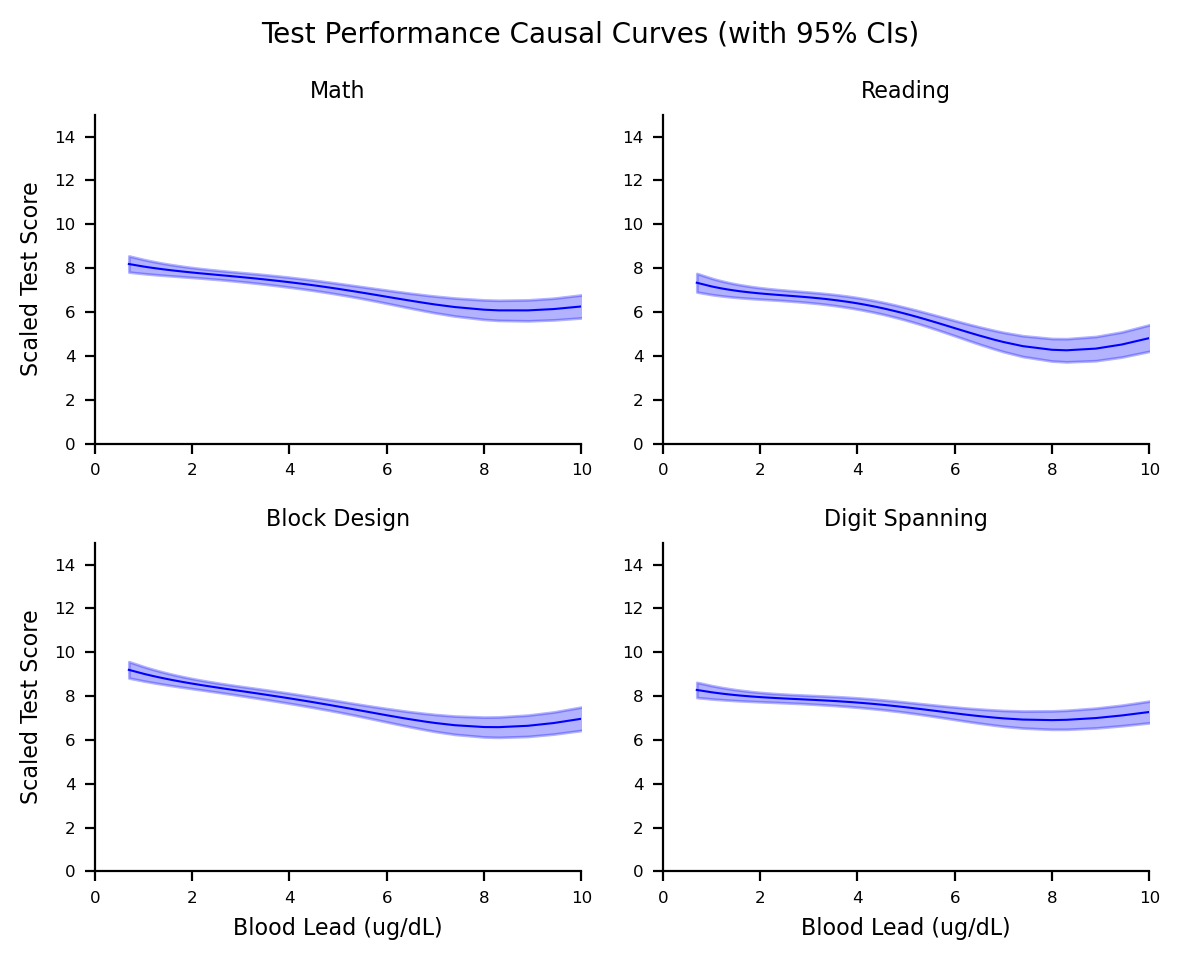

In [7]:
result_class = [['math_CDRC', 'reading_CDRC'], ['block_CDRC', 'digit_CDRC']]

result_name = [['Math', 'Reading'], ['Block Design', 'Digit Spanning']]

def plot_mean_and_CI(axs, i, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[i,j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[i,j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [6, 5]

fig, axs = plt.subplots(2, 2)

for i in [0,1]:
    for j in [0,1]:

        # Plotting quantities
        treat = results_dict[result_class[i][j]]['Treatment']
        mean = results_dict[result_class[i][j]]['Causal_Dose_Response']
        lb = results_dict[result_class[i][j]]['Lower_CI']
        ub = results_dict[result_class[i][j]]['Upper_CI']
        plot_mean_and_CI(axs, i, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

        # Labels
        axs[0,0].set_ylabel('Scaled Test Score', fontsize = 8)
        axs[0,1].set_ylabel('')
        axs[1,0].set_ylabel('Scaled Test Score', fontsize = 8)
        axs[1,1].set_ylabel('')
        axs[1,0].set_xlabel('Blood Lead (ug/dL)', fontsize = 8)
        axs[1,1].set_xlabel('Blood Lead (ug/dL)', fontsize = 8)

        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)

        axs[i,j].spines["top"].set_visible(False)
        axs[i,j].spines["right"].set_visible(False)

        axs[i,j].set_xlim(0, 10)
        axs[i,j].set_ylim(0, 15)
        
        axs[i,j].tick_params(axis='both', which='major', labelsize=6)


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Test Performance Causal Curves (with 95% CIs)", fontsize = 10)

These plots show the purported causal relationship between blood lead values and cognitive test results in four different test types. We have adjusted for confounding by child age, sex (assumed to be binary in this case), child race, the parent's education level, smoking exposure, food insecurity, and whether the child was admitted to a NICU as an infant. In the case of the **reading** test our results show that reducing the population's blood lead levels from 8 mcg/dL to 2 mcg/dL would result in an effect of about a 2 point test increase in the population. 

We assume we've captured all of the major confounding variables in this analysis but we can never be 100% sure. So while we've done the best we can to identify the causal effect, it's important to have a measure of caution about these results (as with all analyses).

<div class="alert alert-success">
    <h3>BONUS EXERCISE: It's been suggested before that lead exposure might "mediate" the relationship between low income and lower cognitive scores. This is, neighborhoods with lower incomes tend have older homes with lead paint problems. If you have extra time, feel free to try using the `causal-curve` package's `Mediation` tool. This will tell you the extent to which blood lead exposure mediates income and any test score (when all three are continuous variables) </h3>
    

<h3>If the percent mediation is high, that might indicate that lead exposure is the primary cause connecting lower income to cognitive scores in the country. If it is a moderate or low percentage, than it's just a piece of a larger puzzle of multiple factors. </h3>

</div>


### Exploring how BLLs mediate the relationship between income and cognitive outcomes

In [8]:
med = Mediation(
    bootstrap_draws=500,
    bootstrap_replicates=100,
    spline_order=3,
    n_splines=5,
    random_seed=111,
    verbose=True,
)

med.fit(
    T=df["PIR"],
    M=df["BLL"],
    y=df["Math"],
)

med_results = med.calculate_mediation(ci = 0.95)

Using the following params for the mediation analysis:
{   'bootstrap_draws': 500,
    'bootstrap_replicates': 100,
    'lower_grid_constraint': 0.01,
    'max_iter': 100,
    'n_splines': 5,
    'random_seed': 111,
    'spline_order': 3,
    'treatment_grid_num': 10,
    'upper_grid_constraint': 0.99,
    'verbose': True}
Beginning main loop through treatment bins...
***** Starting iteration 1 of 9 *****
***** Starting iteration 2 of 9 *****
***** Starting iteration 3 of 9 *****
***** Starting iteration 4 of 9 *****
***** Starting iteration 5 of 9 *****
***** Starting iteration 6 of 9 *****
***** Starting iteration 7 of 9 *****
***** Starting iteration 8 of 9 *****
***** Starting iteration 9 of 9 *****


Mean indirect effect proportion:
            0.1979 (0.1908 - 0.3205)
            


In [9]:
# Use cubic interpolation to create plot of relationship between poverty-income ratio and the proportion of mediation by BLLs
f = interp1d(med_results['Treatment_Value'], med_results['Proportion_Indirect_Effect'], kind='cubic')
PIR_grid = np.linspace(0.23, 3.10, num=100, endpoint=True)

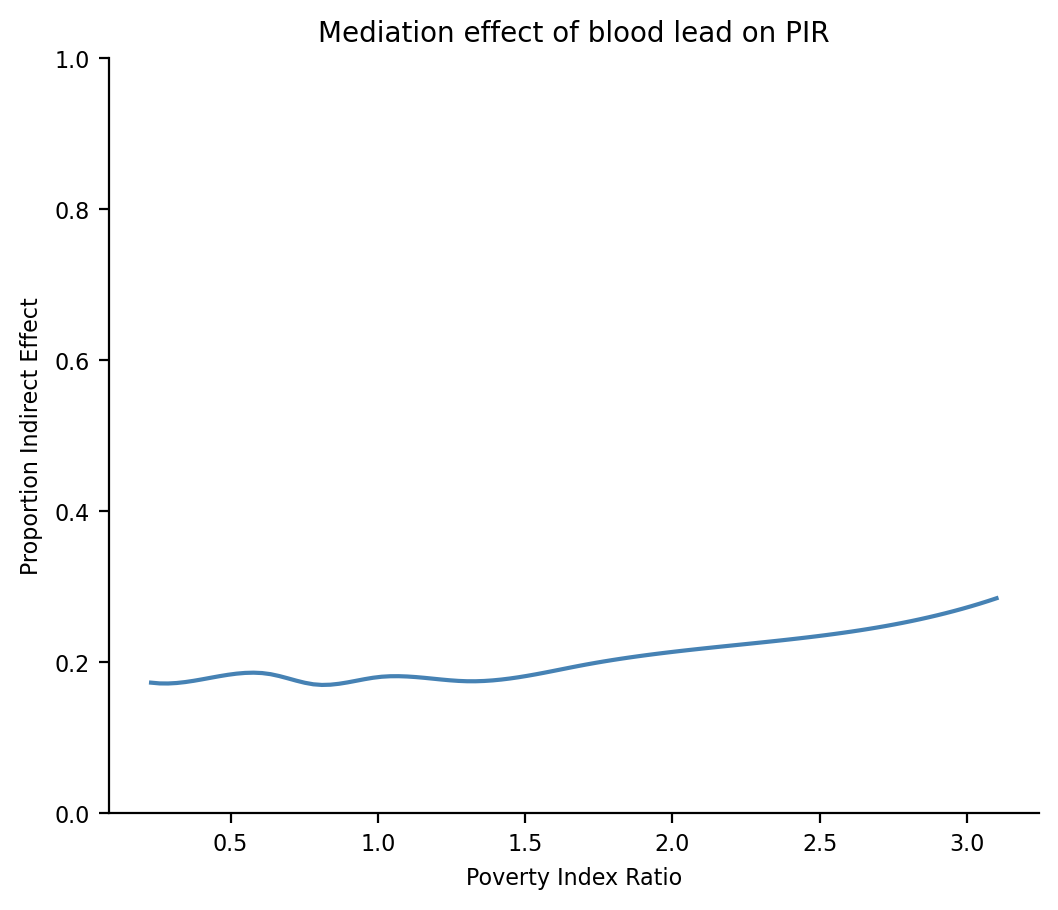

In [10]:
ax = plt.subplot(111)  
ax.plot(PIR_grid, f(PIR_grid), color = 'steelblue')
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
ax.set_ylabel('Proportion Indirect Effect', fontsize = 8)
ax.set_xlabel('Poverty Index Ratio', fontsize = 8)
ax.set_ylim(0,1)
ax.set_title("Mediation effect of blood lead on PIR", fontsize = 10)
ax.tick_params(axis='both', which='major', labelsize=8)

Basically, it looks like lead exposure could explain about 20% of the connection between lower income and lower cognitive test scores in this population. This is a fairly significant fraction, but there are likely many other factors contributing to this relationship.